# ===== FILE SETUP ======# 

In [2]:
import sys
sys.path.append("../") # go to parent dir

In [3]:
FILENAME="_template"
GIT_USER_NAME="SEI-DO3SE"
GIT_REPO_NAME="do3se_phenology"
DEPENDENCIES=[
    ("thermal_time", "github.com/SEI-DO3SE/thermal_time.git"),
    ("do3se_phenology", "github.com/SEI-DO3SE/do3se_phenology.git"),
    ("do3se_met", "github.com/SEI-DO3SE/do3se_met.git"),
]

In [4]:
# Create colab link
from IPython.display import Markdown as md
md(f"""
<a href="https://colab.research.google.com/github/{GIT_USER_NAME}/{GIT_REPO_NAME}/blob/master/notebooks/{FILENAME}.ipynb" target="_parent">
    <img src="https://colab.research.google.com/assets/colab-badge.svg"/>
</a>
""")


<a href="https://colab.research.google.com/github/SEI-DO3SE/do3se_phenology/blob/master/notebooks/_template.ipynb" target="_parent">
    <img src="https://colab.research.google.com/assets/colab-badge.svg"/>
</a>


In [5]:
#@title Download libraries from github
#@markdown Code Hidden
try:
    import importlib
    for name, path in DEPENDENCIES:
        importlib.import_module(name)
except (ImportError, ModuleNotFoundError):
    if 'google.colab' in str(get_ipython()):
        print('Running on CoLab')
        print("""
        This notebook requires access to private repositories. To access follow the steps below:
        1. Get an access key from your github account: https://docs.github.com/en/github/authenticating-to-github/creating-a-personal-access-token
        2. Save the key to a file in the following location on your google drive: `My Drive/access/collabaccess.txt`. The file should include your user on the first line and your token on the second.
        """)
        from google.colab import drive
        drive.mount('/content/drive')

        !mkdir -p ~/.access
        !cp "/content/drive/My Drive/access/collabaccess.txt" ~/.access/config
        import os
        creds = open(f'{os.path.expanduser("~")}/.access/config')
        creds_parsed = creds.read().splitlines()
        user, token = creds_parsed
        for name, path in DEPENDENCIES:
            !pip install git+https://{user}:{token}@{path}
        creds.close()
        creds = None
        creds_parsed = None

# ===== END OF FILE SETUP ======# 
----

# Import dependencies

In [6]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from collections import namedtuple
from dataclasses import dataclass
from typing import List
from itertools import accumulate
from notebook_utils import *
from dataclasses import replace
from copy import deepcopy
from math import (
    floor,
    ceil,
)

In [7]:
from do3se_met.irradiance import *
from thermal_time.calcs import *

In [8]:
%load_ext autoreload
%autoreload 2

# Add local dependencies here
from do3se_phenology.config import (
    ModelConfig,
    PhenologyMethods,
    SpeciesConfig,
    SpeciesPresets,
    Wheat,
    PhenologyKeyDates,
    PhenologyKeyLengths,
    PhenologyLeafKeyLengths,
    DVIMethods,
    LAIMethods,
    TimeTypes,
    KeyDays,
)

from do3se_phenology.plots import (
    plot_ewert_phenology_data,
    plot_f_phen_data,
    plot_leaf_f_phen_data,
)
from do3se_phenology.phyllochron_dvi import (
    calc_emergence_rate,
)

from do3se_phenology.carbon_allocation import (
    calc_partition_coefficients,
)

---

# TITLE

In [9]:
default_expected_model_output = ModelConfig(
    phenology_method=PhenologyMethods.FPHEN_THERMAL_TIME,
    dvi_method=DVIMethods.DISABLED,
    LAI_method=LAIMethods.ESTIMATE_TOTAL,
    time_type=TimeTypes.THERMAL_TIME,
    sgs_time_type=TimeTypes.JULIAN_DAY,
    sgs_key_day=KeyDays.SOWING_DAY,
)



example_species = SpeciesConfig(
    PRESET=SpeciesPresets.WHEAT_SPRING,
    f_tt_emr=0.05,
    f_tt_veg=700 / 2000,
    f_tt_rep=1200 / 2000,
    f_phen_min=0.1,
)

default_expected_species_output = replace(
    Wheat,
    PRESET=SpeciesPresets.WHEAT_SPRING,
    f_tt_emr=0.05,
    f_tt_veg=700 / 2000,
    f_tt_rep=1200 / 2000,
    f_phen_min=0.1,
    fphen_intervals=[
        (0.0, 0.1),
        (100.0, 0.1),
        (400.0, 1.0),
        (1240.0, 1.0),
        (2000.0, 0.0),
    ],
    leaf_fphen_intervals=[
        (0.0, 0.0),
        (1080.0, 0.0),
        (1080.0, 1.0),
        (1240.0, 1.0),
        (1340.0, 1.0),
        (1680.0, 0.7),
        (2000.0, 0.0),
        (2000.0, 0.0),
    ],
    dvi_interval=[
        (0, -1.000000001),
        (100, 0.0),
        (800.0, 1.0),
        (2000.0, 2.0),
    ],
    key_dates=PhenologyKeyDates(
        sowing=20,
        emergence=None,
        harvest=None,
        Astart=None,
        Aend=None,
        mid_anthesis=None,
    ),
    key_dates_td=PhenologyKeyDates(
        sowing=0.0,
        emergence=100.0,
        harvest=2000.0,
        Astart=1080.0,
        Aend=2000.0,
        mid_anthesis=1240.0,
    ),
    key_lengths_td=PhenologyKeyLengths(
        sowing_to_emerge=100.0,
        sowing_to_f_phen_b=400.0,
        sowing_to_f_phen_c=1240.0,
        sowing_to_astart=1080,
        emerg_to_astart=980,
        sowing_to_end=2000.0,
        emerg_to_end=1900.0,
        emerg_to_veg=700.0,
        veg_to_harvest=1200.0,
    ),
    key_lengths_flag_leaf_td=PhenologyLeafKeyLengths(
        tl=920.0 + 280.0,
        tl_em=280.0,
        tl_ma=920.0,
        tl_ep=620.0,
        tl_se=300.0,
        leaf_f_phen_e=160.0,  # 0.08
        leaf_f_phen_g=100.0,  # 0.05
        leaf_f_phen_h=440.0,  # 0.22
        leaf_f_phen_i=760.0,  # 0.38
        # TODO: plant emerg to leaf emer should be different
        # for each population
        plant_emerg_to_leaf_emerg=980 - 280,
    ),
)


In [10]:

T_b, T_o, T_m = [0, 20, 50]
day_count = 365
dd_data = np.array([[d for i in range(24)] for d in range(day_count)]).reshape(day_count * 24)
hrs_data = np.array([[i for i in range(24)] for d in range(day_count)]).reshape(day_count * 24)
demo_temp_data = [24 - abs(hr - 12) for hr in hrs_data]
tsc = demo_temp_data
td = calc_thermal_time_range(tsc, t_b=T_b)

model_config = replace(
    deepcopy(default_expected_model_output),
    phenology_method=PhenologyMethods.SEASON_FRACTION,
)
species_config = replace(
    deepcopy(default_expected_species_output),
)
t_sgs = 0
t_egs = species_config.key_dates_td.harvest

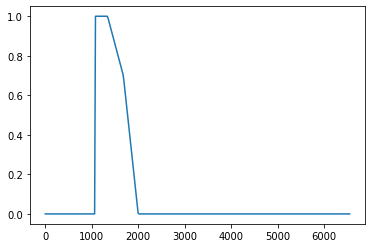

In [11]:
plt.plot(td, np.interp(td,[i[0] for i in  species_config.leaf_fphen_intervals], [i[1] for i in  species_config.leaf_fphen_intervals]))

In [12]:
def plot_leaf_f_phen_data_from_config(species_config, td, ax=plt, ax_box=plt):
    plot_leaf_f_phen_data(
        td,
        np.interp(td,[i[0] for i in  species_config.leaf_fphen_intervals], [i[1] for i in  species_config.leaf_fphen_intervals]),
        species_config.leaf_f_phen_a,
        species_config.leaf_f_phen_b,
        species_config.key_lengths_flag_leaf_td.leaf_f_phen_e,
        species_config.key_lengths_flag_leaf_td.leaf_f_phen_g,
        species_config.key_lengths_flag_leaf_td.leaf_f_phen_h,
        species_config.key_lengths_flag_leaf_td.leaf_f_phen_i,
        species_config.key_dates_td.Astart,
        species_config.key_dates_td.sowing,
        species_config.key_dates_td.harvest,
        ax=ax,
        ax_box=ax_box,
    )
    # f phen
def plot_f_phen_data_from_config(species_config, td, ax=plt, ax_box=plt):
    plot_f_phen_data(
        td,
        np.interp(td,[i[0] for i in  species_config.fphen_intervals], [i[1] for i in  species_config.fphen_intervals]),
        species_config.key_dates_td.sowing,
        species_config.key_dates_td.harvest,
        species_config.key_lengths_td.sowing_to_emerge,
        species_config.key_lengths_td.sowing_to_f_phen_b,
        species_config.key_lengths_td.sowing_to_f_phen_c,
        species_config.key_lengths_td.sowing_to_end,
        ax=ax,
        ax_box=ax_box,
        box_y_start=10,
    )

def plot_ewert_phenology_data_from_config(species_config, td, ax=plt, ax_box=plt):
    td_dd_list = [t - species_config.key_dates_td.sowing for t in td]
    t_astart = species_config.key_lengths_td.sowing_to_astart
    t_lma = species_config.key_lengths_flag_leaf_td.tl_ma
    t_lep = species_config.key_lengths_flag_leaf_td.tl_ep
    t_lem = species_config.key_lengths_flag_leaf_td.tl_em
    f_LA = [max(0, min(1, 1 - (td_dd - t_astart) / (t_lma))) for td_dd in td_dd_list]
    growing = [max(0, min(1,  (td_dd -(t_astart - t_lem)) / (t_lem))) for td_dd in td_dd_list]
    fO3_l = 1
    f_LS = [max(0, min(1, 1 - ((td_dd - t_astart - t_lep) / (t_lma / fO3_l - t_lep))))
            for td_dd in td_dd_list]
    
    ax.plot(td, growing, label="flag_growing")

    plot_ewert_phenology_data(
        td,
        f_LA,
        f_LS,
        species_config.key_lengths_flag_leaf_td.tl_em,
        species_config.key_lengths_flag_leaf_td.tl_ma,
        species_config.key_lengths_flag_leaf_td.tl_ep,
        species_config.key_lengths_flag_leaf_td.tl_se,
        species_config.key_dates_td.sowing,
        species_config.key_dates_td.harvest,
        species_config.key_dates_td.Astart,
        ax=ax,
        ax_box=ax_box,
        box_y_start=17,
    )

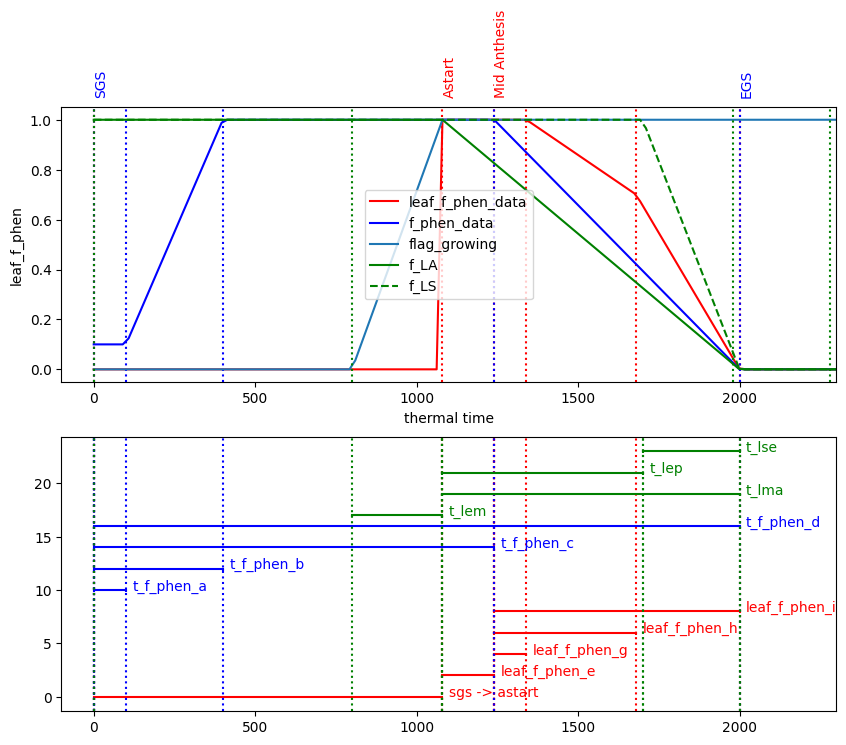

In [13]:
fig, axs = plt.subplots(ncols=1, nrows=2, figsize=(10,8), dpi=100)
plot_leaf_f_phen_data_from_config(species_config, td, ax=axs[0], ax_box=axs[1])
plot_f_phen_data_from_config(species_config, td, ax=axs[0], ax_box=axs[1])
plot_ewert_phenology_data_from_config(species_config, td, ax=axs[0], ax_box=axs[1])

# Setup axes
axs[0].set_xlim((t_sgs - 100, t_egs + 300))
axs[1].set_xlim((t_sgs - 100, t_egs + 300))
axs[0].set_xlabel("thermal time")
axs[0].set_ylabel("leaf_f_phen")
axs[0].legend()


# Carbon Allocation

In [14]:
from matplotlib import pyplot as plt

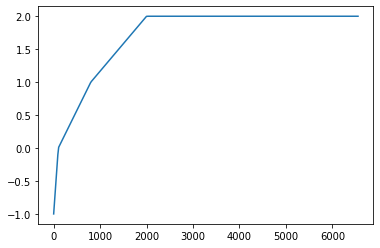

In [15]:
td_at_sgs = species_config.key_dates_td.sowing
tt_emr = species_config.key_lengths_td.sowing_to_emerge
tt_veg = species_config.key_lengths_td.emerg_to_veg
tt_rep = species_config.key_lengths_td.veg_to_harvest

dvi_x = [td_at_sgs, td_at_sgs + tt_emr, td_at_sgs +
            tt_emr + tt_veg, td_at_sgs + tt_emr + tt_veg + tt_rep]
dvi_y = [-1, 0, 1, 2]
dvi = np.interp(td, dvi_x, dvi_y)
plt.plot(td, dvi)

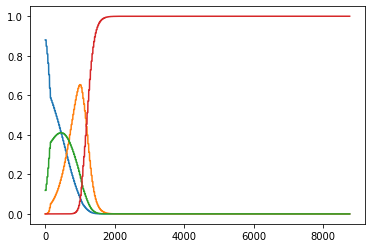

In [16]:

[    a_root,
    a_leaf,
    a_stem,
    b_root,
    b_leaf,
    b_stem,] =        [  18.5,
         16.0,
         18.0,
         -20.0,
         -15.0,
         -18.5,]
p_root,p_leaf,p_stem,p_harv = list(zip(*[calc_partition_coefficients(d, a_root,
    a_leaf,
    a_stem,
    b_root,
    b_leaf,
    b_stem,) for d in dvi]))
    
plt.plot(p_root)
plt.plot(p_leaf)
plt.plot(p_stem)
plt.plot(p_harv)

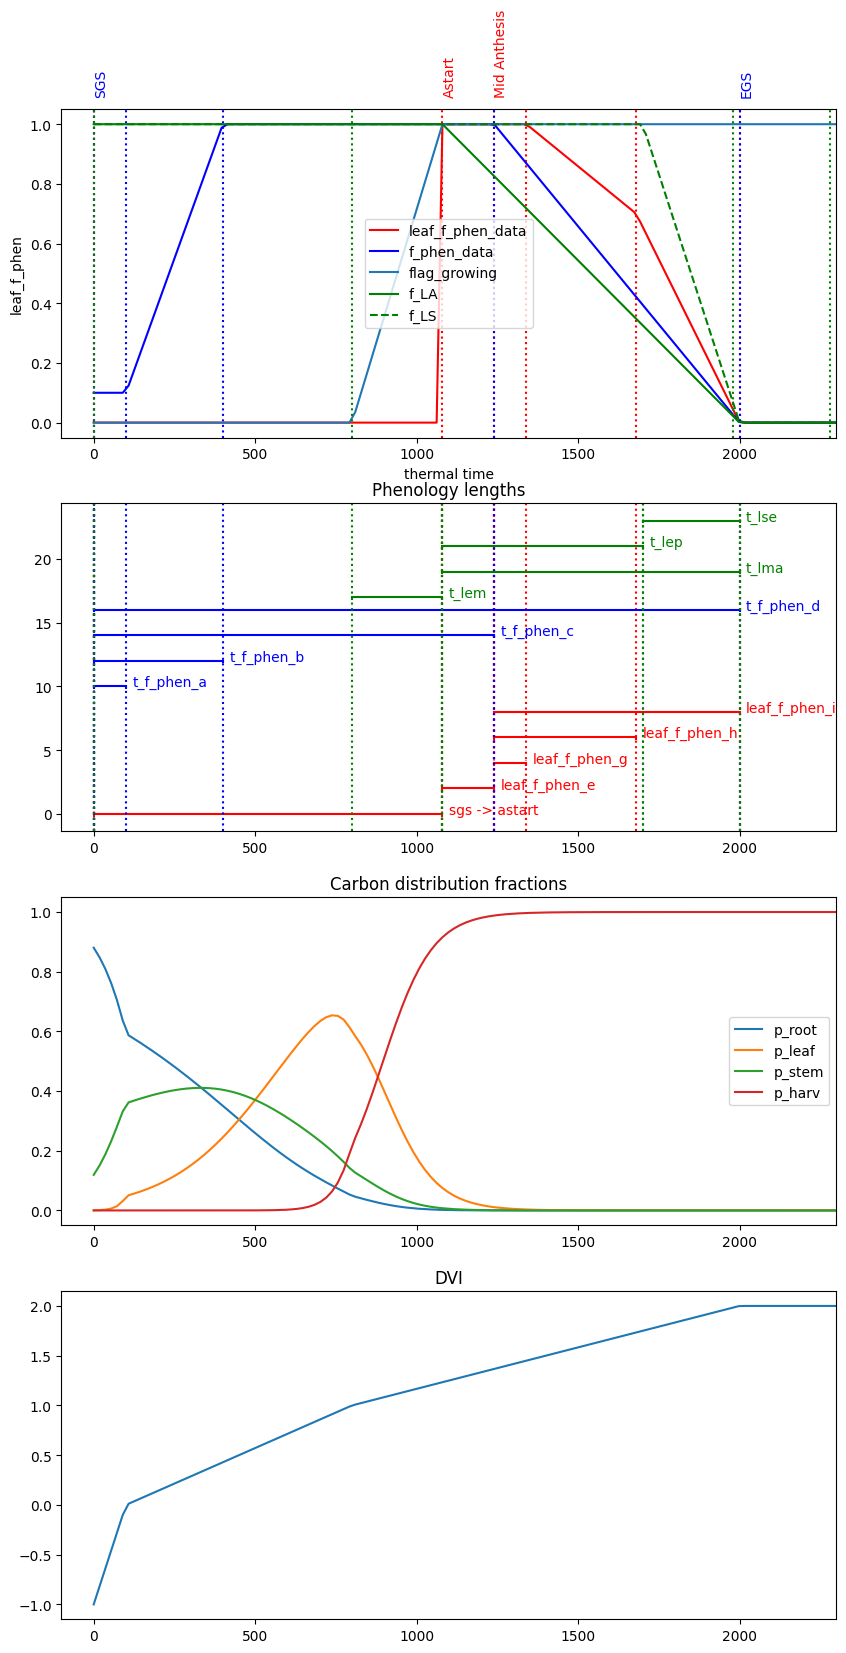

In [26]:
fig, axs = plt.subplots(ncols=1, nrows=4, figsize=(10,20), dpi=100)

# axs[0].set_title("Phenology")
axs[1].set_title("Phenology lengths")

plot_leaf_f_phen_data_from_config(species_config, td, ax=axs[0], ax_box=axs[1])
plot_f_phen_data_from_config(species_config, td, ax=axs[0], ax_box=axs[1])
plot_ewert_phenology_data_from_config(species_config, td, ax=axs[0], ax_box=axs[1])


axs[2].set_title("Carbon distribution fractions")
axs[2].plot(td, p_root, label="p_root")
axs[2].plot(td, p_leaf, label="p_leaf")
axs[2].plot(td, p_stem, label="p_stem")
axs[2].plot(td, p_harv, label="p_harv")

axs[3].plot(td, dvi)
axs[3].set_title("DVI")

# Setup axes
axs[0].set_xlim((t_sgs - 100, t_egs + 300))
axs[1].set_xlim((t_sgs - 100, t_egs + 300))
axs[2].set_xlim((t_sgs - 100, t_egs + 300))
axs[3].set_xlim((t_sgs - 100, t_egs + 300))
axs[0].set_xlabel("thermal time")
axs[0].set_ylabel("leaf_f_phen")
axs[0].legend()
axs[2].legend()
plt.show()

# Multiple Populations

In [28]:
nP = 3

In [29]:
emergence_rate = calc_emergence_rate(nP, species_config.key_lengths_flag_leaf_td.plant_emerg_to_leaf_emerg)
emergence_rate

0.002857142857142857

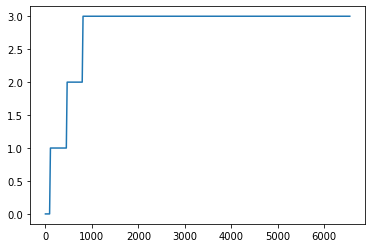

In [30]:
emerged_leaf_populations_count = [min(nP, ceil(t * emergence_rate)) for t in td - species_config.key_lengths_td.sowing_to_emerge]
plt.plot(td, emerged_leaf_populations_count)

In [44]:
def get_growing_populations(nP: int, td, leaf_population_t_emerg: List[float], leaf_population_t_lems: List[float]) -> List[bool]:
    """Calculate which leaf populations are still growing"""
    growing_populations = [False for _ in range(nP)]
    for iP in range(nP):    
        t_emerg = leaf_population_t_emerg[iP]
        t_lem = leaf_population_t_lems[iP]
        growing_populations[iP] = t_emerg < td <= t_emerg + t_lem
    return growing_populations
def vert_line(ax, x, ylim, **kwargs):
    ax.plot([x,x], ylim, **kwargs)

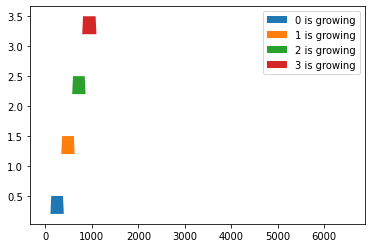

In [146]:
def get_growing_populations_from_config(species_config, nP):
    emergence_rate = calc_emergence_rate(nP, species_config.key_lengths_flag_leaf_td.plant_emerg_to_leaf_emerg)
    emerged_leaf_populations_count = [min(nP, ceil(t * emergence_rate)) for t in td - species_config.key_lengths_td.sowing_to_emerge]
    td_dd_list = [t - species_config.key_dates_td.sowing for t in td]
    last_t_emerg = species_config.key_lengths_flag_leaf_td.plant_emerg_to_leaf_emerg + species_config.key_dates_td.sowing + species_config.key_lengths_td.sowing_to_emerge
    t_lem = species_config.key_lengths_flag_leaf_td.tl_em
    leaf_population_t_emerg = np.array([t for (i, c), t in zip(enumerate(emerged_leaf_populations_count), td) if c >= 1 and c > emerged_leaf_populations_count[i-1] and c < nP] + [last_t_emerg])
    leaf_population_t_lems = [t_lem for _ in range(nP)]
    growing_populations_all = [get_growing_populations(nP, td, leaf_population_t_emerg, leaf_population_t_lems) for td in td_dd_list]
    return growing_populations_all, emerged_leaf_populations_count
def plot_growing_populations_from_config(species_config, nP, ax=plt):
    td_dd_list = [t - species_config.key_dates_td.sowing for t in td]
    growing_populations_all, emerged_leaf_populations_count = get_growing_populations_from_config(species_config, nP)
    for iP in range(nP):
            b = np.array([g[iP] for g in growing_populations_all])
            ax.fill_between(td_dd_list, iP+0.2, iP+0.2 + (b*0.3), label=f"{iP} is growing")
            ax.legend()
    # ax.plot(td, emerged_leaf_populations_count, label="total emerged pops")
    ax.legend()
plot_growing_populations_from_config(species_config, 4)

<ipython-input-147-ff6f61b4a51b>:27: RuntimeWarning: invalid value encountered in double_scalars
  sum(g[i+1:])*p/sum(g) if ff == 0 or sum(g) == 0 else p * (ff+sum(g[i+1:])) / sum(g) if i < len(g) else (p * ff)/sum(g)
<ipython-input-147-ff6f61b4a51b>:27: RuntimeWarning: invalid value encountered in true_divide
  sum(g[i+1:])*p/sum(g) if ff == 0 or sum(g) == 0 else p * (ff+sum(g[i+1:])) / sum(g) if i < len(g) else (p * ff)/sum(g)


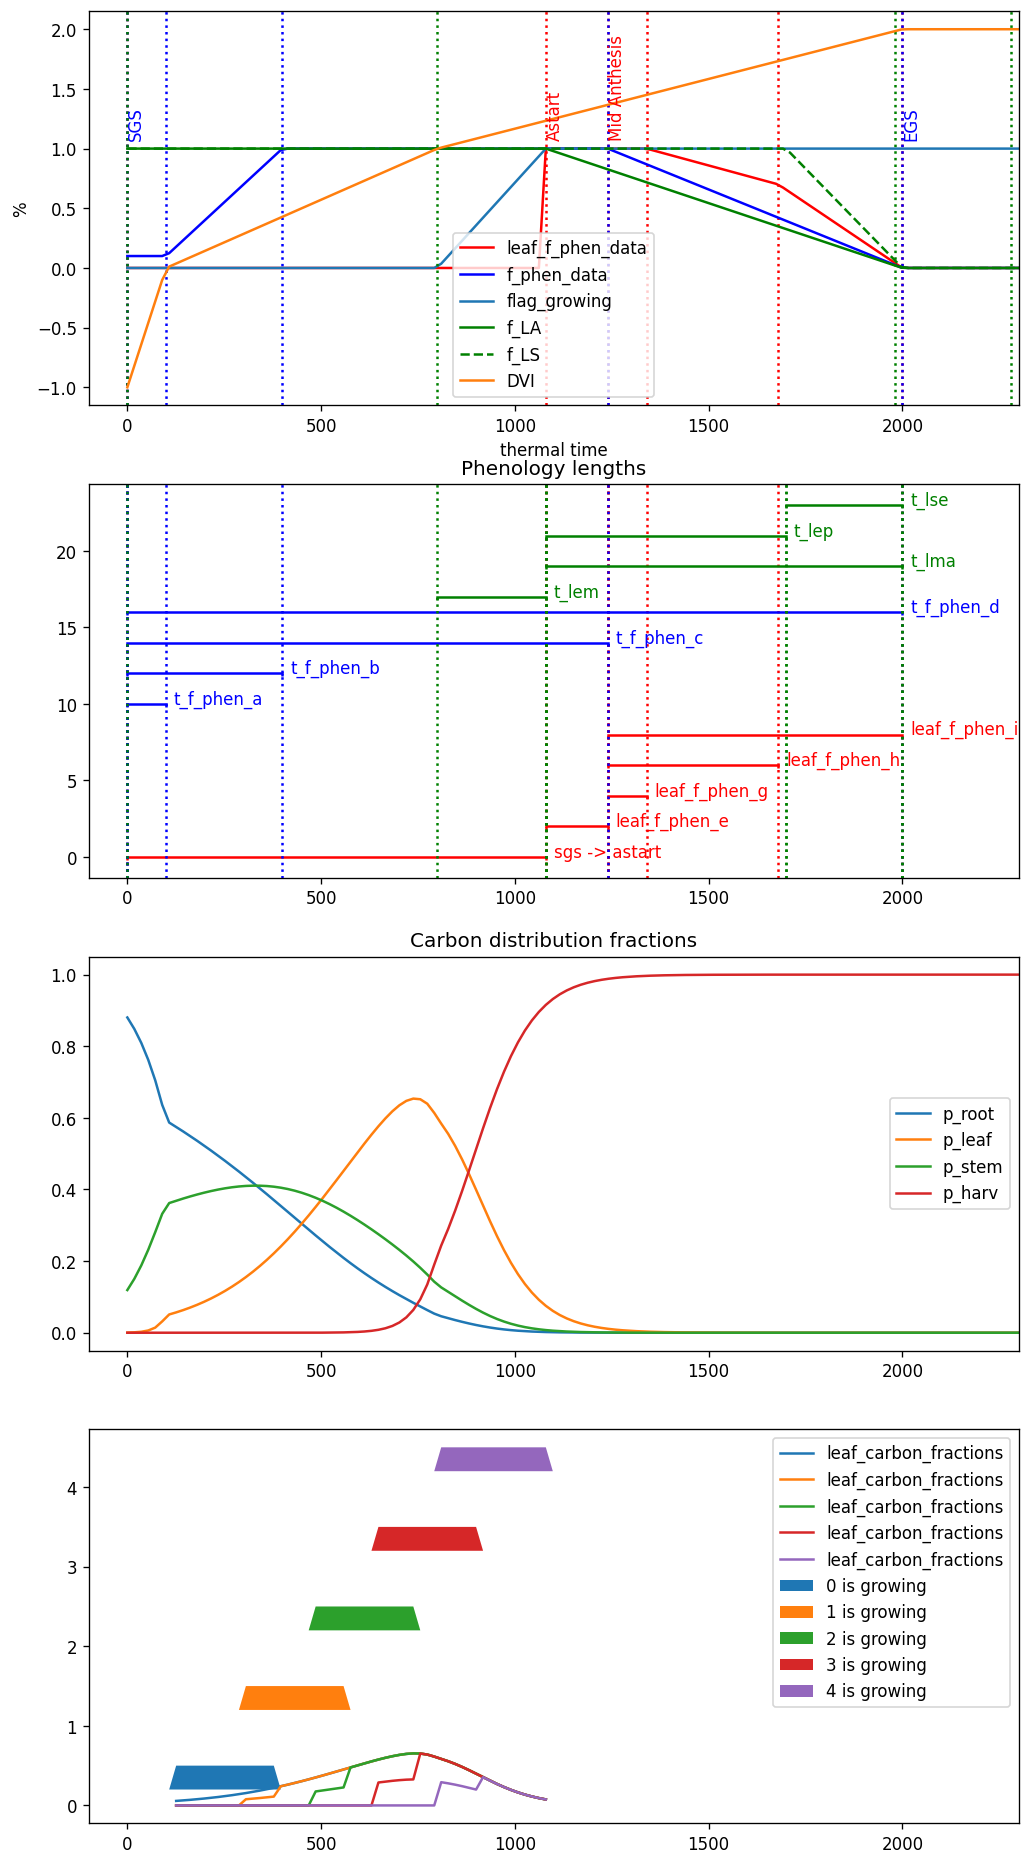

In [147]:
fig, axs = plt.subplots(ncols=1, nrows=4, figsize=(10,20), dpi=120)
nP=5
# axs[0].set_title("Phenology")
axs[1].set_title("Phenology lengths")

plot_leaf_f_phen_data_from_config(species_config, td, ax=axs[0], ax_box=axs[1])
plot_f_phen_data_from_config(species_config, td, ax=axs[0], ax_box=axs[1])
plot_ewert_phenology_data_from_config(species_config, td, ax=axs[0], ax_box=axs[1])


axs[2].set_title("Carbon distribution fractions")
axs[2].plot(td, p_root, label="p_root")
axs[2].plot(td, p_leaf, label="p_leaf")
axs[2].plot(td, p_stem, label="p_stem")
axs[2].plot(td, p_harv, label="p_harv")

axs[0].plot(td, dvi, label="DVI")
plot_growing_populations_from_config(species_config, nP, ax=axs[3])

growing_populations_all, emerged_leaf_populations_count = get_growing_populations_from_config(species_config, nP)

leaf_carbon_fracs = [[
    sum(g[i+1:])*p/sum(g) if ff == 0 or sum(g) == 0 else p * (ff+sum(g[i+1:])) / sum(g) if i < len(g) else (p * ff)/sum(g)
    for i, ff in enumerate(g)] for g, p in zip(growing_populations_all, p_leaf)]
axs[3].plot(td, leaf_carbon_fracs, label="leaf_carbon_fractions")

# Setup axes
axs[0].set_xlim((t_sgs - 100, t_egs + 300))
axs[1].set_xlim((t_sgs - 100, t_egs + 300))
axs[2].set_xlim((t_sgs - 100, t_egs + 300))
axs[3].set_xlim((t_sgs - 100, t_egs + 300))
axs[0].set_xlabel("thermal time")
axs[0].set_ylabel("%")
axs[0].legend()
axs[2].legend()
axs[3].legend()
plt.show()




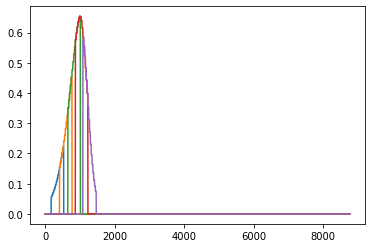

In [148]:
leaf_carbon_fracs = [[ff*p for ff in g] for g, p in zip(growing_populations_all, p_leaf)]
plt.plot(leaf_carbon_fracs)

<ipython-input-140-dd2589583fc0>:5: RuntimeWarning: invalid value encountered in double_scalars
  sum(g[i+1:])*p/sum(g) if ff == 0 or sum(g) == 0 else p * (ff+sum(g[i+1:])) / sum(g) if i < len(g) else (p * ff)/sum(g)
<ipython-input-140-dd2589583fc0>:5: RuntimeWarning: invalid value encountered in true_divide
  sum(g[i+1:])*p/sum(g) if ff == 0 or sum(g) == 0 else p * (ff+sum(g[i+1:])) / sum(g) if i < len(g) else (p * ff)/sum(g)


(0.0, 2000.0)

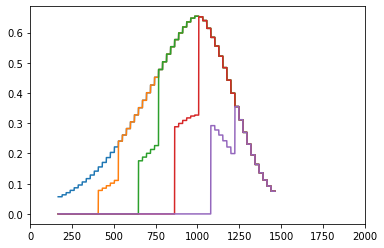

In [140]:
# leaf_carbon_fracs = [[
#     None if ff == 0 or sum(g) == 0 else p * (ff+sum(g[0:i])) / sum(g) if i > 0 else (p * ff)/sum(g)
#     for i, ff in enumerate(g)] for g, p in zip(growing_populations_all, p_leaf)]
leaf_carbon_fracs = [[
    sum(g[i+1:])*p/sum(g) if ff == 0 or sum(g) == 0 else p * (ff+sum(g[i+1:])) / sum(g) if i < len(g) else (p * ff)/sum(g)
    for i, ff in enumerate(g)] for g, p in zip(growing_populations_all, p_leaf)]
plt.plot(leaf_carbon_fracs)
# plt.fill(leaf_carbon_fracs)
plt.xlim(0,2000)
